<a href="https://colab.research.google.com/github/titwan37/GCLRrepo/blob/main/PingEchoHandshakeAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Pre requisites
import csv
import json
import pandas as pd
from io import StringIO
from datetime import datetime

In [ ]:
#@title Mounting Drive
from google.colab import drive
drive.mount('/content/drive') # , force_remount=True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Config
source_folder = 'C:/Users/falempia/Downloads/'
source_folder = '/content/drive/MyDrive/CoLab_inbox/'
target_folder = 'C:/Users/falempia/Downloads/'
target_folder = '/content/drive/MyDrive/Colab_output/'
source_filename_log = 'OPCUAService1.log'   #

In [ ]:
#@title Regex Patterns
import re
patternOrigin = re.compile(r'[[](?P<timestamp>.*)[]][[]Thread-(?P<threadID>\d*)[]][[](?P<severity>\w+)[]][[](?P<serviceName>\S+)[]]\s[>](?P<message>.*)[<]')
patternTransactionValue = re.compile(r'TRIGGER <TRANSACTION value:(?P<transactionValue>\d*)')
patternTransactionValueSent = re.compile(r'Write transaction trigger .*, trigger value: (?P<transactionValueSent>\d+)')
patternResultOfMethod = re.compile(r'configName: (?P<machineMethodName>.*)[,]')
patternCatchStationNb = re.compile(r'(?P<stationNumber>\b\d{17}\b)')
patternInCallID = re.compile(r'IN_iCallID, (?P<inCallID>\d+)')
#patternResultOfMethod = re.compile(r'Results of Method --> configName: (?P<resOfMethodName>.*), imsApiName')
patternMethodName = re.compile(r'methodName:in:String --> cfRocheCESR.(?P<methodName>\w+)')
patternWriteHSKValue = re.compile(r'Write messaging handshake .* handshake value: (?P<WriteHandshakeValue>\d+)')
patternExecuteTimes = re.compile(r'(Read time|Execute time|Write time|Trigger write time|complete): (\d+(?:\.\d+)?ms)')
patternMsgEvtReceived = re.compile(r'Messaging Event received for config: (?P<machineCF>\w+), message address "(?P<CF>\w+)", message text: {"[^"]+":"(?P<stationNumber>[^"]+)","[^"]+":"(?P<reportedCallId>[^"]+)","[^"]+":"(?P<topicValue>[^"]+)"}') # '(stationNumber|reportedCallId|topic):"([^"]+)"'
patternNodeChanges_STD = re.compile(r'^^[[](?P<timestamp>[\d|.|:|\s|,]*)[]][[](?P<PublishTask>.*)[]][[](?P<Severity>\S*)[]][[](?P<channel>\S*)[]]\s(?P<message>[>]Node Changed: Server-->\s(?P<nodeServerName>\w+), Node-->\s(?P<nodeID>\S+)[,]\scurrent Value-->\s(?P<currentNodeValue>\S+)[,]\sprevious Value-->\s(?P<previousNodeValue>\S+)[,]\sStatus Code-->\s(?P<statusCode>\S+)[,]\sStatus Code Name-->\s(?P<statusCodeName>\S+)[<])')
patternNodeChanges_CODESYS = re.compile(r'^[[](?P<timestamp>[\d|.|:|\s|,]*)[]][[](?P<PublishTask>.*)[]][[](?P<Severity>\S*)[]][[](?P<channel>\S*)[]]\s(?P<message>[>]Node Changed: Server-->\s(?P<nodeServerName>\w+), Node-->\s[|]var[|]CODESYS Softmotion RTE x64\s[.](?P<nodeID>(\w+)[.](\w+)[.](?P<customFunction>\w+)[.](\w+))[,]\scurrent Value-->\s(?P<currentNodeValue>\S+)[,]\sprevious Value-->\s(?P<previousNodeValue>\S+)[,]\sStatus Code-->\s(?P<statusCode>\S+)[,]\sStatus Code Name-->\s(?P<statusCodeName>\S+)[<])')
pattern_dico = {
    'Origin': patternOrigin,
    'MethodName': patternMethodName,
    'ResultOfMethod': patternResultOfMethod,
    'InCallID': patternInCallID,
    'TransactionValue': patternTransactionValue,
    'TransactionValueSent': patternTransactionValueSent,
    'ExecuteTimes': patternExecuteTimes,
    'CatchStationNb': patternCatchStationNb,
    'MsgEvtReceived': patternMsgEvtReceived,
    'WriteHSKValue': patternWriteHSKValue,
    'NodeChanges_STD': patternNodeChanges_STD,
    'NodeChanges_CODESYS': patternNodeChanges_CODESYS
    }


In [ ]:
#@title Tools
def getShapeSize(label='', df=None):
  # Assuming you have a DataFrame called 'df'
  if df is None:
    return
  else:
    dimensions = df.shape
    num_rows = dimensions[0]
    num_columns = dimensions[1]
    print(f"Dataframe={label} has Number of rows: {num_rows} and columns : {num_columns}")
    return dimensions

#how to convert df['timestampString'] to datetime?
def adjustTimestamps(year, timestampString):
    try:
      # 'hh:mm:ss.000'
      if (str(timestampString).startswith(str(year))):
          stringformat1 = f"%Y.%d.%m. %H:%M:%S,%f"
          # self.datetime = date.fromisoformat(timestampString)
          datetime_out = datetime.strptime(timestampString, stringformat1)
          # Format a string with the str.format () method
          stringformat2 = f"%Y.%m.%dT%H:%M:%S.%f"
          #self.timestamp = self.datetime.strftime(stringformat2)
          return datetime_out
      else:
        if (year>1970):
            timestampString = (str(year) + '.' + timestampString)
            # print(timestampString)
            stringformat1 = f"%Y.%d.%m. %H:%M:%S,%f"
            # self.datetime = date.fromisoformat(timestampString)
            datetime_out = datetime.strptime(timestampString, stringformat1)
            # Format a string with the str.format () method
            stringformat2 = f"%Y.%m.%dT%H:%M:%S.%f"
            #self.timestamp = self.datetime.strftime(stringformat2)
            return datetime_out
    except ValueError:
        print(f'ValueError  for {timestampString}')
        return None


## Vis Lib

In [ ]:
#@title history Plots
# !pip install matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

import matplotlib as mpl
from cycler import cycler

# Set a default color cycle
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y', 'c', 'm', 'k'])  # Add your desired colors
# print(mpl.rcParams['axes.prop_cycle'])
# colors = mpl.rcParams['axes.prop_cycle'].by_key().get('color', ['k'])  # Default to black if no colors are available
# Reset rcParams to default values
import matplotlib as mpl

mpl.rcdefaults()
print(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)

# Set the default font size to 8
#mpl.rcParams['font.size'] = 8

#@title Create the figure with multiple subplots
def createhistplotSeriesY(figsize, df, ySeries, title='Histogram by', enableXLogScale=False):
  # Check if DataFrame is empty and print contents for debugging
  if df.empty:
      print("DataFrame is empty!")
      return None

  # Create the figure with multiple subplots
  num_plots = len(ySeries) - 1
  fig, axs = plt.subplots(1, num_plots, figsize=figsize, layout='constrained')

  # Loop through each subplot and plot the histogram
  for i, ax in enumerate(axs):
      sns.countplot(data=df, y=ySeries[0], hue=ySeries[i+1], ax=ax, palette='bright')
      ax.set_title(title + f' {ySeries[i+1]}', fontsize=10)
      # Add annotations for ySeries[i+1] on the histogram
      #for p in ax.patches: ax.annotate(f"{ySeries[i+1]}: {p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height() + 0.5), ha='center', va='bottom', fontsize=6)

      # Add annotations for ySeries[i+1] on the histogram
      for p in ax.patches:
          ax.annotate(f"{ySeries[i+1]}", (p.get_x() + p.get_width() / 2, p.get_height() - 3), ha='center', va='top', fontsize=6, xytext=(0, -3), textcoords="offset points")
      # Reduce y-axis tick font size on the subplot
      ax.tick_params(axis='y', labelsize=8)
      ax.tick_params(axis='x', labelsize=8)
      if enableXLogScale:
        ax.set_xscale('log')  # Enable logscale on x-axis
        #ax.set_xscale('log', basex=2)  # Set x-axis to log scale with base 2
      # Set the legend font size
      ax.legend(fontsize=8, title_fontsize=9, loc='best') # adjust the font size to your liking
      # Sort y-axis in ascending order
      y_values = sorted(df[ySeries[0]].unique(), reverse=False)
      ax.set_yticks(y_values)
      ax.set_yticklabels(y_values, fontsize=8)

  # Show the figure
  plt.show()
  return fig

# prompt: Using dataframe rdf: make a horizontal bar plot of threadID in y-axis and lineCount in x-axis
def createHBarPlot(df, serieColumnName, abysseColumn):
  import altair as alt
  alt.Chart(df).mark_bar().encode(
      y=serieColumnName,
      x=abysseColumn
  )

def create2HBarPlots(df, columns, figsize=(10, 5.2)):
  # Define a default color palette
  #default_palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['k'])
  # Get the number of columns
  colNumb = len(columns)
  # Create subplots with 1 row and x columns
  fig, axs = plt.subplots(1, colNumb, figsize=figsize, layout='constrained')
  if len(columns) == 1:
    axes = [axs]
  # Inside a loop where you plot each bar chart:
  for i, column in enumerate(columns):
      # Plot the first chart on the left subplot
      ax = axs[i]
      # Access color from the palette, handling the case of an empty palette
      #color = default_palette[i % len(default_palette)] if default_palette else 'k'
      # Check if the group is empty before plotting
      grouped = df.groupby(column).size()
      #grouped = df.groupby(column).value_counts()
      if not grouped.empty:
        grouped.plot(kind='barh', ax=ax, color=sns.palettes.mpl_palette('Dark2')) # sns.palettes.mpl_palette('Dark2')
        ax.spines[['top', 'right']].set_visible(False)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel('Count')
      else:
          print(f"Warning: No data to plot for column '{column}'")

  for ax in fig.axes:
      # Enable grid lines on the x-axis
      ax.xaxis.grid(True)
      # Set the font size for y-axis tick labels
      ax.tick_params(axis='y', labelsize=7)
      ax.tick_params(axis='x', labelsize=7)
      ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

  # Adjust layout and display the plot
  plt.tight_layout()
  # Adjust the spacing between subplots
  #plt.subplots_adjust(wspace=1.4)
  # Show the plot
  plt.show()
  return fig

def create4HBarPlots(df, columns, figsize=(10, 5.2)):
  # Create subplots with 2 row and 2 columns
  fig, axs = plt.subplots(2, 2, figsize=figsize, layout='constrained')
  # Plot the first chart on the left subplot
  ax = axs[0,0]
  df.groupby(columns[0]).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=ax)
  ax.spines[['top', 'right']].set_visible(False)
  # Plot the second chart on the right subplot
  ax = axs[0,1]
  # Reverse the order of group names
  df.groupby(columns[1]).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=ax)
  ax.spines[['top', 'right']].set_visible(False)
  # Plot the first chart on the left subplot
  ax = axs[1,0]
  df.groupby(columns[2]).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=ax)
  ax.spines[['top', 'right']].set_visible(False)
  ax = axs[1,1]
  df.groupby(columns[3]).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=ax)
  ax.spines[['top', 'right',]].set_visible(False)
  # Set titles for the subplots
  axs[0,0].set_title(columns[0])
  axs[0,1].set_title(columns[1])
  axs[1,0].set_title(columns[2])
  axs[1,1].set_title(columns[3])
  # Enable grid lines on the x-axis
  for ax in fig.axes: ax.xaxis.grid(True)
  # Adjust the spacing between subplots
  #plt.subplots_adjust(wspace=1.4)

  # Show the plot
  plt.show()
  return fig

def createDualHistoChartLog(figsize, df, ySerie1, ySerie2, hueSerie, isYaxisLogSerie1=False, isYaxisLogSerie2=False):
    # Group the DataFrame by 'serialNumber (SN)' and 'machineName', and get the count of each group
    grouped_df = df.groupby([ySerie1, hueSerie]).size().reset_index(name='count')
    # Plot the grouped bar plot
    fig, axs = plt.subplots(2, 1, figsize=figsize, layout='constrained', sharex=False) #
    ax = axs[0]
    sns.barplot(y='count', x=ySerie1, hue=hueSerie, data=grouped_df, ax=ax) # , palette=sns.color_palette('Dark2')
    # Remove the top and right spines from the plot
    ax.spines[['top', 'right']].set_visible(False)
    # Set the x-axis tick locations
    maxLoc = min(len(df[ySerie1].unique()), 50)
    # Set the tick locator for the x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(maxLoc))
    # Set the font size for x-axis tick labels
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    # Rotate the x-axis labels by 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    # Set y-axis to logarithmic scale
    if isYaxisLogSerie1: ax.set_yscale('log')

    # Group the DataFrame by 'machineName' and get the count of each group
    grouped_df2 = df.groupby([ySerie2, hueSerie]).size().reset_index(name='count')
    # Plot the histogram
    ax = axs[1]
    sns.barplot(y='count', x=ySerie2, hue=hueSerie, data=grouped_df2, ax=ax) # , palette=sns.color_palette('Dark2')
    ax.spines[['top', 'right',]].set_visible(False)
    # Set the x-axis tick locations
    maxLoc = min(len(df[ySerie2].unique()), 50)
    # Set the tick locator for the x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(maxLoc))
    # Set the font size for x-axis tick labels
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    # Rotate the x-axis labels by 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    # Set y-axis to logarithmic scale
    if isYaxisLogSerie2: ax.set_yscale('log')
    return fig

def createDualScatterPP(figsize, df, xSerie, ySerie, hueSerie):
  # Plot the grouped bar plot
  fig, axs = plt.subplots(2, 1, figsize=figsize, layout='constrained')
  # Create the scatter plot
  ax=axs[0]
  df.plot(kind='scatter', x='rowIndex', y=ySerie, s=32, alpha=.8,ax = ax)
  # Add a series based on 'isReal'
  sns.scatterplot(data=df, x='rowIndex', y=ySerie, hue=hueSerie, ax=ax, alpha=.8)
  # Remove the top and right spines from the plot
  ax.spines[['top', 'right']].set_visible(False)
  # Rotate the x-axis labels by 45 degrees
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  # Create the scatter plot
  ax=axs[1]
  df.plot(kind='scatter', x=xSerie, y=ySerie, s=32, alpha=.5, ax=ax)
  # Add a series based on 'isReal'
  sns.scatterplot(data=df, x=xSerie, y=ySerie, hue=hueSerie, alpha=.5, ax=ax)
  # Remove the top and right spines from the plot
  ax.spines[['top', 'right']].set_visible(False)
  # Rotate the x-axis labels by 45 degrees
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  # Show the plot
  plt.show()
  return fig

def createhistplotY(figsize, df, ySerie):
    # Check if the DataFrame is empty
    if df.shape[0] == 0:
        #raise ValueError("The DataFrame is empty.")
        print("The DataFrame is empty.")
        return None
    # Check if the specified column is empty
    if df[ySerie].empty:
        #raise ValueError(f'The {ySerie} column is empty.')
        print(f'The {ySerie} column is empty.')
        return None
    # Check if the specified column contains integers
    if not pd.api.types.is_integer_dtype(df[ySerie]):
        # If not, use value_counts() to get the counts of unique values
        value_counts = df[ySerie].value_counts()
        # Create a new DataFrame for plotting
        rdf = value_counts.reset_index()
        rdf.columns = [ySerie, 'count']  # Rename columns for clarity
        # Check if rdf is empty
        if rdf.empty:
            #raise ValueError("The DataFrame for plotting is empty.")
            print("The DataFrame for plotting is empty.")
            return None
        print(f'Create the barplot of {ySerie} counts')
        #print(rdf['count'])
        print(rdf)
        # Create the histogram
        fig, ax = plt.subplots(figsize=figsize, layout='constrained')
        sns.barplot(data=rdf, y=ySerie, x='count', ax=ax)
    else:
        # Drop rows with NaN in the specified column
        rdf = df.dropna(subset=[ySerie])

        print(f'Create the histoplot of {ySerie}')

        # Create the histogram
        fig, ax = plt.subplots(figsize=figsize, layout='constrained')
        sns.histplot(data=rdf, y=ySerie, ax=ax)

    # Show the figure
    plt.show()
    return fig

def createhistplotLog(figsize, rdf, ySerie, hueSerie):
  # Assuming your DataFrame is named 'df'
  table = rdf.groupby([ySerie, hueSerie]).size().reset_index(name='count')
  # Create the histogram
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  #fig, axs = plt.subplots(2, 1, figsize=(10, 16), constrained_layout=True)
  #ax = axs[0]
  sns.histplot(data=rdf, y=ySerie, hue=hueSerie,ax=ax)
  # Remove the top and right spines from the plot
  #ax.spines[['top', 'right']].set_visible(False)
  # Set the x-axis tick locations
  # maxLoc = len(rdf['machineName'].unique())
  # ax.xaxis.set_major_locator(plt.MaxNLocator(maxLoc))
  # Rotate the x-axis labels by 45 degrees
  # ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  # Set y-axis to logarithmic scale if desired
  ax.set_xscale('log')
  # Move the legend next to the chart and reduce the font size
  #legend = ax.legend(loc='center left', fontsize='small')
  #legend = ax.legend()
  # Adjust the legend size
  # legend.get_frame().set_linewidth(0.5)  # Set the legend frame linewidth
  # for text in legend.get_texts():
  #     text.set_fontsize(8)  # Set the font size of the legend text

  #plt.legend(fontsize=6, labelspacing=0.5, ncol=6, loc='lower center')
  # Place the legend outside the chart on the right-hand side
  #legend.set_bbox_to_anchor((1.1, 0.8))
  # Assign labels to the plot elements
  # handles, labels = ax.get_legend_handles_labels()
  # ax.legend(handles, labels)
  # Show the figure
  plt.show()
  return fig

def createSimpleCountTable(figsize, rdf, ySeries):
  # Assuming your DataFrame is named 'df'
  table = rdf.groupby(ySeries).size().reset_index(name='count')
  # Sort the table by the 'methodName' column
  if len(ySeries)>0:
    table = table.sort_values(ySeries[0])
  # Create the histogram
  fig, ax = plt.subplots(figsize=figsize) # , layout='constrained'
  ax.axis('off')  # Hide the axis
  ax.table(cellText=table.values, colLabels=table.columns, loc='center')
  # # Show the figure
  plt.show()
  return fig

def createDoubleCountTable(figsize, rdf, ySerie1, ySerie2):
  # Assuming your DataFrame is named 'df'
  table = rdf.groupby([ySerie1, ySerie2]).size().reset_index(name='count')
  table = table.sort_values(by='count', ascending=False)  # Sort values by descending counts
  # Create the histogram
  fig, ax = plt.subplots(figsize=figsize) # , layout='constrained'
  ax.axis('off')  # Hide the axis
  ax.table(cellText=table.values, colLabels=table.columns, loc='center')
  # # Show the figure
  plt.show()
  return fig

def showFirstLastDatePerMachine(df, group_column='methodName', legend=''):
  min_date = df['datetime'].min()
  max_date = df['datetime'].max()
  print (f'Legend:{legend}, Min date: {min_date}, Max date: {max_date}')
  result_df = df.groupby(group_column)['datetime'].agg(['first', 'last'])
  fig = createSimpleCountTable((8,4), result_df, [group_column,'first', 'last'])
  return result_df

_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: ['-layers', 'OptimizePlus']
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: black
axes.facecolor: white
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: black
axes.labelpad: 4.0
axes.labelsize: medium
axes.labelweight: normal
axes.linewidth: 0.8
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
axes.spines.bottom: True
axes.spines.left: True
axes.spines

In [ ]:
#@title createHeatmap2D
def createHeatmap2D(figsize, rdf, group_columns, columnY, enableLogScale=False, annot_fontsize=6):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=figsize)
  # Create a DataFrame for the 2D histogram
  df_2dhist = pd.DataFrame({
      x_label: grp[columnY].value_counts()
      for x_label, grp in rdf.groupby(group_columns)
  })
  if (enableLogScale):
    # Replace zeros with NaN to avoid log(0) issues
    df_2dhist = df_2dhist.replace(0, np.nan)
    # Create the heatmap with a logarithmic scale
    sns.heatmap(np.log1p(df_2dhist), cmap='viridis', annot=True, cbar_kws={'label': 'Log Scale'}, annot_kws={"size": annot_fontsize})
    #plt.xlabel(', '.join(group_columns))  # Join group columns for the label
  else:
    sns.heatmap(df_2dhist, cmap='viridis')
  plt.xlabel(group_columns)
  plt.xticks(fontsize=6, rotation=90)  # Adjust the font size and rotation of x-axis labels
  plt.yticks(fontsize=7)
  _ = plt.ylabel(columnY)
  return plt

In [ ]:
#@title ChronoSerie Plots
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

def _chronoPlot_series(palette, series, serieColumnName, hueSerieName, series_name, series_index=0, displayLegend=True):
  try:
    # print(f'series_index={series_index} series_name={series_name}')
    # print(f'series={series[serieColumnName]}')
    # print(f'hueSerieName={series[hueSerieName]}')
    offset = series_index * 0.2  # Adjust the offset value as per your requirement
    xs = series['datetime']
    ys = series[serieColumnName]
    zs = series[hueSerieName].astype('category')  # Convert hue column to categorical data type

    # Define a mapping of binMachineCondition to markers
    marker_mapping = {
        'Start': 's',  # Square
        'Run': 'o',  # Circle
        'Stop': 'X',   # X
        'Undefined': '^',  # Triangle
        'Condition4': 'D',  # Diamond
    }

    # Get the marker for the current series based on the binMachineCondition
    marker = marker_mapping.get(series_name[1], 'o')  # Default to circle if not found

    # Check if both elements of the tuple are empty strings
    if (len(series_name)>1):
      if (series_name[0] == '' and series_name[1] == ''):
          series_name_str = 'NoName'  # Assign a single name if both are empty
      else:
          series_name_str = '-'.join(series_name)  # Join tuple elements with '_'

    #print(f"index: {series_index} plotting series {hueSerieName} with label: {series_name}")

    if displayLegend:
      # Use sns.lineplot with a label for the legend
      sns.lineplot(x=xs, y=ys, label=series_name, color=palette[series_index % len(palette)], marker=marker, markersize=6)
      #sns.lineplot(label=series_name, x=xs, y=ys, hue=zs, palette=palette, marker='o', markersize=6)
      #sns.lineplot(x=xs, y=ys, label=series_name, marker='o', markersize=6)
    else:
      sns.lineplot(x=xs, y=ys, color=palette[series_index % len(palette)], marker=marker, markersize=6)

    # Plot lines between markers for similar serial numbers
    if (series_index > 0 and series_index<len([palette])):
        prev_series = palette[series_index - 1]
        prev_xs = prev_series['datetime']
        prev_ys = prev_series[serieColumnName] + (series_index - 1) * 0.1  # Adjust the offset value as per your requirement
        common_serialNumbers = set(series['serialNumber']).intersection(set(prev_series['serialNumber']))

        for serialNumber in common_serialNumbers:
            current_index = series[series['serialNumber'] == serialNumber].index[0]
            prev_index = prev_series[prev_series['serialNumber'] == serialNumber].index[0]
            plt.plot([prev_xs[prev_index], xs[current_index]], [prev_ys[prev_index], ys[current_index]], color='gray', linestyle='--')

  except KeyError:
    print("Key not found:" + series_name)
  except TypeError:
    print("TypeError:" + hueSerieName)


def createChronoSeriePlot(figsize, df, series, plot_order=None, suptitle='', displayLegend=True):
    ###
    ### createChronoSeriePlot
    ### ---------------------
    fig, ax = plt.subplots(figsize=figsize) # , layout='constrained'
    palette = list(sns.palettes.mpl_palette('Dark2'))
    if 'datetime' in df.columns:
        df = df.sort_values('datetime', ascending=True)
    if(len(series)>1):
      serieColumnName = series[0]
      hueSerieName= series[1]
      # make it unique categories
      # Modify this line to handle object dtype
      y_values = df[serieColumnName].unique()
      # Convert y_values to numeric if it's not already
      if not pd.api.types.is_numeric_dtype(y_values):
          y_values = pd.Categorical(y_values).codes
          print(f'y_values  Categorical ={y_values}')
          ax.set_yticks(range(len(y_values)))
      elif df[serieColumnName].dtype == 'object':
          y_values = sorted(df[serieColumnName].astype(str).unique(), key=str.lower) # Sort unique values for object dtype
          # Set y-axis tick labels to the sorted unique values
          ax.set_yticks(y_values)
      else:
          y_values = sorted(np.unique(df[serieColumnName].astype(str).values), key=str.lower) # Sort unique values for non-object dtype
          ax.set_yticks(y_values)
      print(f'{serieColumnName} = {y_values}')
      # Set y-axis tick labels to the sorted unique values
      ax.set_yticklabels(y_values, fontsize=8)
      # Sort the series_name based on the plot_order
      if plot_order is not None:
        if (serieColumnName in df.columns):
          df[serieColumnName] = pd.Categorical(df[serieColumnName].astype(str), categories=plot_order, ordered=True)
          df = df.sort_values(serieColumnName)
          print(f"Values from {serieColumnName} are sorted by categories: {plot_order}")

      for i, (series_name, series) in enumerate(df.groupby([serieColumnName, hueSerieName], observed=False)): #
          #print(f'{i}: Plotting series_name={series_name}')
          _chronoPlot_series(palette, series, serieColumnName, hueSerieName, series_name, i, displayLegend)
          plt.xlabel('datetime')
          _ = plt.ylabel(series_name)

      sns.despine(fig=fig, ax=ax)
      # Set the desired date format for the x-axis tick labels
      date_format = mdates.DateFormatter('%Y-%m-%d %H:%M')  # Example format: YYYY-MM-DD
      ax.xaxis.set_major_formatter(date_format)
      # Rotate the x-axis tick labels if needed
      plt.xticks(rotation=66, fontsize=7)  # Adjust the rotation angle as needed
      # disable legend
      if displayLegend:
        #fig.legend(title=serieColumnName, bbox_to_anchor=(1, 1), loc='upper left', fontsize=7)
        legend = ax.legend(title=serieColumnName, bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10, fontsize=6)

      # Enable grid lines on the x-axis
      for ax in fig.axes: ax.xaxis.grid(True)

      yaxis_mapping=None
      # Enable sorting values on the y-axis
      if (yaxis_mapping):
        # Set the y-axis order based on the mapping table
        ax.set_yticks([yaxis_mapping[method] for method in df[serieColumnName]])
        # Set the y-axis labels based on the method names
        ax.set_yticklabels(df[serieColumnName].astype(str))

      if (plot_order):
        # Set y-ticks to match the number of labels
        ax.set_yticks(range(len(plot_order)))
        # Set the y-axis tick labels based on the desired order
        ax.set_yticklabels(plot_order)

    # Add title at the top left corner
    if suptitle:
      if (len(suptitle)>0):
        fig.suptitle(suptitle, x=0.05, y=0.95, fontsize=11, ha='right', va='top')
        #fig.suptitle(suptitle, y=0.02, fontsize=12, ha='center') # Add title at the bottom

    # Adjust the spacing between subplots
    #plt.tight_layout()
    # Show the figure
    plt.show()
    return fig

def createChronoSeriePlotPerDay(figsize, df, series, plot_order=None, suptitle='', filename='ChronoSeriePlotPerDay_'):
    for day, day_data in df.groupby(df['datetime'].dt.date):
        fig = createChronoSeriePlot(figsize, day_data, series, plot_order, suptitle+day.strftime('%Y-%m-%d'))
        fig.savefig(f'{filename}_{day.strftime("%Y-%m-%d")}.png')
        plt.close(fig)

def createChronoSeriesPlotPerColumn(figsize, df, ySeries, pivotColumn, filenameWO):
  """
  Creates a chronoplot for each unique value in the pivotColumn.
  """
  group_names = df[pivotColumn].unique()
  print(f'Number of groups {pivotColumn} = {len(group_names)}\n {group_names}')
  data_groups = df.groupby(pivotColumn)
  groups = data_groups.groups
  print (f'groups={groups}')
  groupsL =  len(groups)
  print(f'Number of groups {pivotColumn} = {groupsL}')

  # Create a chronoplot for each group
  for i, (name, group) in enumerate(data_groups):
    print(f'{i} - Graph is created for {name}')
    #ySeries_unique = sorted(df[ySeries[0]].unique(), key=str.lower)
    #ySeries_unique = sorted(np.unique(df[ySeries[0]].values, axis=0), key=str.lower) # Sort alphabetically (case-insensitive)
    #print(f'{i} - Serie {ySeries[0]} = [{ySeries_unique}]')
    fig = createChronoSeriePlot(figsize, group, ySeries, plot_order=None, suptitle=name, displayLegend=False)
    names = df[ySeries[0]].unique()
    print(f'{i} - Serie {ySeries[0]} = [{names}]')
    # Save the plot as PNG
    fig.savefig(f'{filenameWO}_for{name}.png')
    print(f'Graph was saved as {filenameWO}_for{name}.png')
    plt.close(fig)
    #plt.tight_layout()
    #return fig

In [ ]:
#@title PyramidGraph
def createPyramidGraph(figsize, df, groupName, sortingColumn, splitcolumn, names, suptitle='ALL'):
  # Create the data for groups and population distribution
  # Filter out rows with empty serialNumber entries
  df = df[df[groupName] != '']
  # Sort SN_groups based on the 'datetime' column
  sorted_indices = df.groupby(groupName)[sortingColumn].min().sort_values().index
  SN_groups = df[groupName].unique()
  #SN_groups = [item for item in SN_groups if item != '']
  # print(SN_groups)
  # print(len(SN_groups))

  # Sort left_counts and right_counts based on sorted_indices
  left_counts = df[df[splitcolumn]==names[0]].groupby(groupName).size().reindex(sorted_indices, fill_value=0)
  # print(len(left_counts))
  right_counts = df[df[splitcolumn]==names[1]].groupby(groupName).size().reindex(sorted_indices, fill_value=0)
  # print(len(right_counts))
  # counts = df[df['methodName'] == 'cfpCameraIn'].groupby('serialNumber').size()
  # Convert SN_groups to a pandas Series and reindex it based on sorted_indices
  #SN_groups = pd.Series(SN_groups).reindex(sorted_indices).values

  # Filter SN_groups to match the length of left_counts and right_counts
  SN_groups = SN_groups[:len(left_counts)]

  #print(SN_groups)
  title = ', '.join(names)
  # Create the figure and axes
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)  # Create two subplots, one for the pyramid graph and one for the table
  # Plot the male population as a bar graph
  ax1.barh(SN_groups, -left_counts, label=names[0], color=sns.palettes.mpl_palette('Dark2'), alpha=0.5)
  # Plot the female population as a bar graph with negative values to mirror the graph
  ax1.barh(SN_groups, right_counts, label=names[1], color=sns.palettes.mpl_palette('Dark2'))
  # Set the x-axis label
  ax1.set_xlabel(title + " counts", fontsize=8)
  ax1.tick_params(axis='y', labelsize=7)
  # Set the y-axis label
  ax1.set_ylabel(groupName, fontsize=8)
  ax1.tick_params(axis='x', labelsize=7)
  # Add a vertical line at x=0
  ax1.axvline(x=0, color='black', linestyle='--')
  # Add a title
  ax1.set_title(title + " Pyramid for "+ suptitle, fontsize=10)
  # Add a legend
  ax1.legend(fontsize=8)

  # Create a table on ax2
  table_data = {groupName: SN_groups, names[0]: left_counts, names[1]: right_counts}
  # Add the 'plateType' column to the table_data dictionary
  if ('plateType' in df.columns):
    table_data['plateType'] = df.groupby(groupName)['plateType'].first().reindex(SN_groups)
  table_df = pd.DataFrame(table_data)  # Convert the table data to a DataFrame
  table = ax2.table(cellText=table_df.values, colLabels=table_df.columns, loc='center')
  table.auto_set_font_size(False)
  table.set_fontsize(8)
  table.scale(1, 0.9)

  # Hide the axis and remove the spines for ax2
  ax2.axis('off')
  ax2.spines['top'].set_visible(False)
  ax2.spines['bottom'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax2.spines['right'].set_visible(False)

  # Adjust the spacing between subplots
  plt.tight_layout()
  # Display the plot
  plt.show()
  # Show the figure
  return fig

## Data Model Design

In [ ]:
#@title DM PublishTask
import re

class PublishTask:
  def __init__(self, year, record_matchNodeChanges, type):
      #self.year = year
      #self.patternTimestamp = re.compile(r'[\d|.|:|\s|,]*')
      timestampString = record_matchNodeChanges.group('timestamp')
      datetime = adjustTimestamps(year, timestampString)
      self.datetime = pd.to_datetime(datetime)
      self.PublishTask = record_matchNodeChanges.group('PublishTask')
      self.severity = record_matchNodeChanges.group('Severity')
      self.serviceName = record_matchNodeChanges.group('channel')
      self.message = record_matchNodeChanges.group('message')
      if type == 'STD':
        ## STD
        self.nodeServerName = record_matchNodeChanges.group('nodeServerName')
        self.nodeID = record_matchNodeChanges.group('nodeID')
        # self.customFunction = record_matchNodeChanges.group('customFunction')
        self.currentNodeValue = record_matchNodeChanges.group('currentNodeValue')
        self.previousNodeValue = record_matchNodeChanges.group('previousNodeValue')
        self.statusCode = record_matchNodeChanges.group('statusCode')
        self.statusCodeName = record_matchNodeChanges.group('statusCodeName')

      if type == 'CODE':
        ## CODE
        self.nodeServerName = record_matchNodeChanges.group('nodeServerName')
        self.nodeID = record_matchNodeChanges.group('nodeID')
        self.customFunction = record_matchNodeChanges.group('customFunction')
        self.currentNodeValue = record_matchNodeChanges.group('currentNodeValue')
        self.previousNodeValue = record_matchNodeChanges.group('previousNodeValue')
        self.statusCode = record_matchNodeChanges.group('statusCode')
        self.statusCodeName = record_matchNodeChanges.group('statusCodeName')


In [ ]:
#@title DM Thread
import re

class Thread:
    def __init__(self, thread_id):
        self.data = {}
        self.threadID = thread_id
        self.ThreadRange = None
        self.date       = None
        self.datetime   = None
        self.starttime  = None
        self.endtime    = None
        self.severity   = None
        self.readTime = None
        self.executeTime = None
        self.completeTime = None
        self.writeTime = None
        self.triggerWriteTime = None
        self.WriteHandshakeValue = ''
        self.serviceName = None
        self.customFunction = None
        self.stationNumber = None
        self.callID = None
        self.topicValue = None
        self.messages    = ''
        self.NbMessages = 0
        self.machineMethodName = None # Initialize machineMethodName to handle cases where no match is found
        self.transactionValueGet = None # Initialize transactionValue to handle cases where no match is found
        self.transactionValueSet = None # Initialize transactionValue to handle cases where no match is found

    def to_dict(self):
        """Convert instance to  dictionary."""
        return {"date": self.date
            ,"datetime": self.datetime
            ,"callID": self.callID
            ,"ThreadRange": self.ThreadRange
            ,"completeTime": self.completeTime
            ,"transactionValueGet": self.transactionValueGet # Add transactionValue to the dictionary
            ,"transactionValueSet": self.transactionValueSet # Add transactionValue to the dictionary
            ,"triggerWriteTime": self.triggerWriteTime
            ,"WriteHandshakeValue": self.WriteHandshakeValue
            ,"machineMethodName": self.machineMethodName
            ,"customFunction": self.customFunction
            ,"serviceName": self.serviceName
            ,"stationNumber": self.stationNumber
            ,"topicValue": self.topicValue
            ,"threadID": self.threadID
            ,"severity": self.severity
            ,"starttime": self.starttime
            ,"endtime": self.endtime
            ,"readTime": self.readTime
            ,"executeTime": self.executeTime
            ,"writeTime": self.writeTime
            ,"NbMessages": self.NbMessages
            , "messages": self.messages
        }

    def serialize(self):
        """Serialize the instance to a JSON string."""
        return json.dumps(self.to_dict(), default=str)

    @staticmethod
    def serialize_to_json(threads, output_file_path):
        """Serialize a list of instances to a JSON file."""
        with open(output_file_path, mode='w') as jsonfile:
            json.dump([job_step.to_dict() for job_step in threads], jsonfile, default=str, indent=4)

    @staticmethod
    def serialize_to_csv(threads, output_file_path):
        if (len(threads)>0):
            """Serialize a list of instances to a CSV file."""
            with open(output_file_path, mode='w', newline='') as csvfile:
                fieldnames = list(threads[0].to_dict().keys())
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for job in threads:
                    writer.writerow(job.to_dict())

    def calculateDuration(self):
        if self.starttime is not None and self.endtime is not None:
            duration = self.endtime - self.starttime
            # convert in milliseconds
            self.ThreadRange = duration.total_seconds() * 1000
        else:
            self.ThreadRange = None

    def submitDatetime(self, datetime):
        if self.date is None:
            self.date = datetime.date()
        if self.starttime is None:
            self.starttime = datetime
        else:
          if self.starttime > datetime:
            self.starttime = datetime
            self.calculateDuration()
        if self.endtime is None:
            self.endtime = datetime
            self.calculateDuration()
        else:
          if self.endtime < datetime:
            self.endtime = datetime
            self.calculateDuration()

    def process_line(self, year, pattern_dico, line):
        if len(pattern_dico) > 0:
            for pattern_name, pattern in pattern_dico.items():
                #print(f"Processing line with pattern: {pattern_name}")
                line_match = pattern.search(line)
                if line_match:
                    if pattern_name == 'Origin':
                        timestampString = line_match.group('timestamp')
                        datetime = adjustTimestamps(year, timestampString)
                        self.datetime = pd.to_datetime(datetime)
                        self.submitDatetime(self.datetime)
                        self.threadID = line_match.group('threadID')
                        self.severity = line_match.group('severity')
                        self.serviceName = line_match.group('serviceName')
                        #
                        ## Assign messages
                        ### -----------------
                        message = line_match.group('message')
                        if len(message) > 0:
                          if self.messages is None:
                            self.messages = message
                            self.NbMessages+=1
                          else:
                            self.messages += '\n'+ message
                            self.NbMessages+=1

                    elif pattern_name == 'MethodName':
                        self.customFunction = line_match.group('methodName')
                    elif pattern_name == 'ResultOfMethod':
                        self.machineMethodName = line_match.group('machineMethodName')
                    elif pattern_name == 'InCallID':
                        self.callID = line_match.group('inCallID')

                    elif pattern_name == 'TransactionValue':
                        self.transactionValueGet = line_match.group('transactionValue')
                    elif pattern_name == 'TransactionValueSent':
                        self.transactionValueSet = line_match.group('transactionValueSent')

                    elif pattern_name == 'MsgEvtReceived':
                        self.customFunction = line_match.group('CF')
                        self.stationNumber = line_match.group('stationNumber')
                        self.callID = line_match.group('reportedCallId')
                        self.topicValue = line_match.group('topicValue')

                    elif pattern_name == 'ExecuteTimes':
                        #pattern = re.compile(r'(Read time|Execute time|Write time|Trigger write time|complete): (\d+(?:\.\d+)?ms)')
                        durations = re.findall(pattern=pattern, string=line)
                        duration_dict = {name: float(value[:-2]) for name, value in durations}
                        self.completeTime = duration_dict.get('complete', None) # Use get method with a default value
                        self.readTime = duration_dict.get('Read time', None)
                        self.executeTime = duration_dict.get('Execute time', None)
                        self.writeTime = duration_dict.get('Write time', None)
                        self.triggerWriteTime = duration_dict.get('Trigger write time', None) # Use get method with a default value

                    if pattern_name == 'WriteHSKValue':
                        self.WriteHandshakeValue = line_match.group('WriteHandshakeValue')
                    if pattern_name == 'CatchStationNb':
                      if self.stationNumber is None:
                         self.stationNumber = line_match.group('stationNumber')

    def process_lines(self, year, pattern_dico, lines):
        thread_dict = {}
        for line in lines:
            self.process_line(year, pattern_dico, line)

    def to_dataframe(self):
        return pd.DataFrame([self.data])

In [ ]:
#@title extractWorkStationNumber
#@markdown extractWorkStationNumber
def extractWorkStationNumber(args):
    machineNumbers_string = ''
    pattern = r'(\d{19})'  # Regular expression pattern to match 19-digit serial numbers
    if (args is not None):
      machineNumbers = re.findall(pattern, str(args))
      if (len(machineNumbers)>0):
        machineNumbers_string = machineNumbers[0]
      elif (len(machineNumbers)>1):
        machineNumbers_string = ', '.join(machineNumbers)  # Concatenate wo with a delimiter
      else:
        machineNumbers_string = ''
    return machineNumbers_string

#@markdown extractMachineName
def extractMachineName(machineMethodName):
  # Check if machineMethodName is not None before applying rsplit
  if machineMethodName is not None:
    # how to split KLS_301_cfpEcho with the last '_' char from string
    machineName, methodName = machineMethodName.rsplit('_', 1)
    return (machineName, methodName)
  else:
    # Return (None, None) or any suitable default values for missing data
    return (None, None)
#@markdown extractMachineNames
def extractMachineNames(df):
  # how to split for the whole column
  df['machineName'], df['methodName'] = zip(*df['machineMethodName'].map(extractMachineName))
  return df

In [ ]:
#@title Reader
class HandshakeReader:
    def __init__(self, filename, pattern_dico):
        self.filename = filename
        self.pattern_dico = pattern_dico

    @staticmethod
    def process_line(patternOrigin, line):
        match = patternOrigin.search(line)
        if match:
            data = match.groupdict()
            df = pd.DataFrame([data])
            return df
        else:
            return None

    def read_handshake(self, year):
        dfs = []
        threads = []
        publishTasks= []

        with open(self.filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
              ### process lines
              df = HandshakeReader.process_line(patternOrigin, line)
              if df is not None:
                  dfs.append(df)

              if 'TRIGGER <TRANSACTION value' in line:
                # treat
                thread = Thread(year, pattern_dico, line)
                threads.append(thread)

              elif '[OPCUA.Service] >Node Changed: Server' in line:
                # find
                record_matchNodeChanges_STD = patternNodeChanges_STD.search(line)       # NodeChanges standard
                record_matchNodeChanges_CODE = patternNodeChanges_CODESYS.search(line)       # NodeChanges CodeSys
                # treat
                if record_matchNodeChanges_STD:
                  publishTask = PublishTask(year, record_matchNodeChanges_STD, 'STD')
                  publishTasks.append(publishTask)
                elif record_matchNodeChanges_CODE:
                  publishTask = PublishTask(year, record_matchNodeChanges_CODE, 'CODE')
                  publishTasks.append(publishTask)

        ####
        dfs = pd.concat(dfs)
        getShapeSize('dfs', dfs)
        #how to transform publishTasks to dataframe?
        threads_df = pd.DataFrame([vars(s) for s in threads])
        getShapeSize('threads_df', threads_df)
        ####
        publishTasks_df = pd.DataFrame([vars(s) for s in publishTasks])
        getShapeSize('publishTasks_df', publishTasks_df)
        # assuming threads_df and publishTasks_df are your DataFrames
        merged_df = pd.concat([threads_df, publishTasks_df], axis=1)
        #merged_df = pd.merge(threads_df, publishTasks_df, how='outer', suffixes=('_threads', '_publishTasks'))
        return merged_df

In [ ]:
from ast import pattern
#@title Smart Reader
def read_file_in_chunks(file_path, chunk_size=2048):
    with open(file_path, 'r') as file:
        while True:
            chunk = file.readlines(chunk_size)
            if not chunk:
                break
            yield chunk

def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

def group_lines_by_threadID(pattern, lines):
    threadID_lines = {}
    print('Start grouping lines by ThreadID')
    for line in lines:
        match = pattern.search(line)
        if match:
            threadID = match.group('threadID')
            if threadID not in threadID_lines:
                # Initialize the line list with this threadID key
                threadID_lines[threadID] = [line.strip()]
            else:
                # Append to the existing line list for this threadID key
                threadID_lines[threadID].append(line.strip())
    # end
    print(f'End grouping lines by ThreadID with {len(threadID_lines)} threads.')
    return threadID_lines

def process_threadID_group(threadID, year, pattern_dico, lines):
    # Process the lines with the same threadID
    lineCount = len(lines)
    patternCount = len(pattern_dico)
    thread = Thread(threadID)
    #print(f"Processing threadID: {threadID} with  LineCount({lineCount}) with patternCount: {patternCount}")
    thread.process_lines(year, pattern_dico, lines)
    return (threadID, lineCount, thread)

def processLines(year, pattern_dico, lines):
    threadID_lineCounts = []
    print(f'Start processing ({len(lines)}) lines with pattern_dico: {pattern_dico}')
    #print(pattern_dico)
    # Group lines by threadID
    #pattern = re.compile(r'[[]Thread-(?P<threadID>\d*)[]]')
    pattern = pattern_dico['Origin']
    threadID_lines = group_lines_by_threadID(pattern, lines)
    # loop threadID_lines
    for threadID, lines in threadID_lines.items():
        (threadID, lineCount, thread) = process_threadID_group(threadID, year, pattern_dico, lines)
        threadID_lineCounts.append((threadID, lineCount, thread.to_dict()))
    # df
    print(f'End processing ({len(threadID_lines)}) threadGroups with an array of {len(threadID_lineCounts)} items.')
    df = pd.DataFrame(threadID_lineCounts, columns=['threadID', 'lineCount', 'thread'])
    return df


def smartReader(file_path, year, pattern_dico, enable_chunks=False):
    import re
    #pattern = re.compile(r'[[]Thread-(?P<threadID>\d*)[]]')
    pattern = pattern_dico['Origin']
    if enable_chunks==False:
      lines = read_file(file_path)
      lineCount = len(lines)
      #print(f"Processing file: {file_path} with  LineCount({lineCount})")
      df = processLines(year, pattern_dico, lines)
      return df

    elif enable_chunks:
      for chunk in read_file_in_chunks(file_path):
        df = processLines(year, pattern_dico, chunk)
        return df
    else:
      return None

In [ ]:
import os
file_path = source_folder + source_filename_log
# check if file exists ?
fileExist=os.path.exists(file_path)
print(f'File exists: {fileExist}')
rdf = smartReader(file_path, 2024, pattern_dico)
getShapeSize('rdf', rdf)
if (rdf is not None):
  if (rdf.size>4):
    rdf.sample(5)

File exists: True
Start processing (280386) lines with pattern_dico: {'Origin': re.compile('[[](?P<timestamp>.*)[]][[]Thread-(?P<threadID>\\d*)[]][[](?P<severity>\\w+)[]][[](?P<serviceName>\\S+)[]]\\s[>](?P<message>.*)[<]'), 'MethodName': re.compile('methodName:in:String --> cfRocheCESR.(?P<methodName>\\w+)'), 'ResultOfMethod': re.compile('configName: (?P<machineMethodName>.*)[,]'), 'InCallID': re.compile('IN_iCallID, (?P<inCallID>\\d+)'), 'TransactionValue': re.compile('TRIGGER <TRANSACTION value:(?P<transactionValue>\\d*)'), 'TransactionValueSent': re.compile('Write transaction trigger .*, trigger value: (?P<transactionValueSent>\\d+)'), 'ExecuteTimes': re.compile('(Read time|Execute time|Write time|Trigger write time|complete): (\\d+(?:\\.\\d+)?ms)'), 'CatchStationNb': re.compile('(?P<stationNumber>\\b\\d{17}\\b)'), 'MsgEvtReceived': re.compile('Messaging Event received for config: (?P<machineCF>\\w+), message address "(?P<CF>\\w+)", message text: {"[^"]+":"(?P<stationNumber>[^"]+)"

In [ ]:
largethreads = rdf[rdf['lineCount'] >= 7]
getShapeSize('largethreads', largethreads)
print(f'Min lineCount: {largethreads["lineCount"].min()}, Max lineCount: {largethreads["lineCount"].max()}')
largethreads

Dataframe=largethreads has Number of rows: 2985 and columns : 3
Min lineCount: 22, Max lineCount: 140


,threadID,lineCount,thread
0,424185,22,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
1,423698,22,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
3,424656,22,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
4,424192,22,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
6,13,140,"{'date': 2024-08-17, 'datetime': 2024-08-20 22..."
...,...,...,...
4525,87594,25,"{'date': 2024-08-20, 'datetime': 2024-08-20 15..."
4526,87596,25,"{'date': 2024-08-20, 'datetime': 2024-08-20 15..."
4528,87599,25,"{'date': 2024-08-20, 'datetime': 2024-08-20 15..."
4529,87605,25,"{'date': 2024-08-20, 'datetime': 2024-08-20 15..."


In [ ]:
threads_head = rdf.head(30)
smallthreads = rdf[rdf['lineCount'] < 7]
print(f'Min lineCount: {smallthreads["lineCount"].min()}, Max lineCount: {smallthreads["lineCount"].max()}')
getShapeSize('smallthreads', smallthreads)
smallthreads

Min lineCount: 1, Max lineCount: 1
Dataframe=smallthreads has Number of rows: 1548 and columns : 3


,threadID,lineCount,thread
2,424191,1,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
5,424659,1,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
9,425184,1,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
12,425734,1,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
15,426278,1,"{'date': 2024-08-17, 'datetime': 2024-08-17 13..."
...,...,...,...
4522,87368,1,"{'date': 2024-08-20, 'datetime': 2024-08-20 15..."
4524,87375,1,"{'date': 2024-08-20, 'datetime': 2024-08-20 15..."
4527,87598,1,"{'date': 2024-08-20, 'datetime': 2024-08-20 15..."
4530,87607,1,"{'date': 2024-08-20, 'datetime': 2024-08-20 15..."


In [ ]:
#@title Normalize
import pandas as pd
def normalize_thread_data(df):
  # assuming df is your dataframe
  flat_df = pd.concat([df.drop('thread', axis=1), df['thread'].apply(pd.Series)], axis=1)
  # remove overflow of data
  #flat_df.drop('message', axis=1, inplace=True)
  getShapeSize('flat_df', flat_df)
  print(flat_df.columns)
  print (flat_df.head(5))
  return flat_df

ndf = normalize_thread_data(largethreads)
ndf

Dataframe=flat_df has Number of rows: 2985 and columns : 25
Index(['threadID', 'lineCount', 'date', 'datetime', 'callID', 'ThreadRange',
       'completeTime', 'transactionValueGet', 'transactionValueSet',
       'triggerWriteTime', 'WriteHandshakeValue', 'machineMethodName',
       'customFunction', 'serviceName', 'stationNumber', 'topicValue',
       'threadID', 'severity', 'starttime', 'endtime', 'readTime',
       'executeTime', 'writeTime', 'NbMessages', 'messages'],
      dtype='object')
  threadID  lineCount        date                datetime callID  ThreadRange  \
0   424185         22  2024-08-17 2024-08-17 13:44:40.256    267        760.0   
1   423698         22  2024-08-17 2024-08-17 13:44:40.659    267        646.0   
3   424656         22  2024-08-17 2024-08-17 13:47:41.473    268        697.0   
4   424192         22  2024-08-17 2024-08-17 13:47:41.887    268        602.0   
6       13        140  2024-08-17 2024-08-20 22:03:39.310   None  288859348.0   

   completeTim

,threadID,lineCount,date,datetime,callID,ThreadRange,completeTime,transactionValueGet,transactionValueSet,triggerWriteTime,...,topicValue,threadID,severity,starttime,endtime,readTime,executeTime,writeTime,NbMessages,messages
0,424185,22,2024-08-17,2024-08-17 13:44:40.256,267,760.0,705.90,1545,1546,18.20,...,None,424185,INFO,2024-08-17 13:44:39.550,2024-08-17 13:44:40.310,256.52,224.27,206.90,22,\nTRIGGER <TRANSACTION value:1545> received ->...
1,423698,22,2024-08-17,2024-08-17 13:44:40.659,267,646.0,378.46,None,None,NaN,...,30010230600180214/cfpEcho,423698,INFO,2024-08-17 13:44:40.214,2024-08-17 13:44:40.860,0.00,182.99,195.47,22,\nMessaging Event received for config: KLS_301...
3,424656,22,2024-08-17,2024-08-17 13:47:41.473,268,697.0,696.77,1547,1548,14.07,...,None,424656,INFO,2024-08-17 13:47:40.776,2024-08-17 13:47:41.473,259.79,181.41,241.50,22,\nTRIGGER <TRANSACTION value:1547> received ->...
4,424192,22,2024-08-17,2024-08-17 13:47:41.887,268,602.0,394.56,None,None,NaN,...,30010230600180214/cfpEcho,424192,INFO,2024-08-17 13:47:41.285,2024-08-17 13:47:41.887,0.00,173.59,220.97,22,\nMessaging Event received for config: KLS_301...
6,13,140,2024-08-17,2024-08-20 22:03:39.310,None,288859348.0,NaN,None,None,NaN,...,None,13,INFO,2024-08-17 13:49:19.962,2024-08-20 22:03:39.310,NaN,NaN,NaN,140,\nLicense check triger result code: 0\nLicense...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4525,87594,25,2024-08-20,2024-08-20 15:28:05.247,None,328.0,320.54,151,152,23.28,...,None,87594,INFO,2024-08-20 15:28:04.919,2024-08-20 15:28:05.247,23.57,206.71,66.97,25,\nTRIGGER <TRANSACTION value:151> received -> ...
4526,87596,25,2024-08-20,2024-08-20 15:28:05.653,None,328.0,316.07,153,154,17.04,...,None,87596,INFO,2024-08-20 15:28:05.325,2024-08-20 15:28:05.653,23.58,202.68,72.77,25,\nTRIGGER <TRANSACTION value:153> received -> ...
4528,87599,25,2024-08-20,2024-08-20 15:28:06.247,None,313.0,308.77,155,156,11.08,...,None,87599,INFO,2024-08-20 15:28:05.934,2024-08-20 15:28:06.247,46.73,224.56,26.40,25,\nTRIGGER <TRANSACTION value:155> received -> ...
4529,87605,25,2024-08-20,2024-08-20 15:28:06.638,None,297.0,289.81,157,158,13.99,...,None,87605,INFO,2024-08-20 15:28:06.341,2024-08-20 15:28:06.638,41.44,203.23,31.15,25,\nTRIGGER <TRANSACTION value:157> received -> ...


In [ ]:
# prompt: extractWorkStationNumber on ndf from all topicValue that is not null and store the extacted number into a new column called 'workstationNumber'

ndf['workstationNumber'] = ndf['topicValue'].apply(lambda x: extractWorkStationNumber(x) if pd.notnull(x) else None)
extractMachineNames(ndf)


,threadID,lineCount,date,datetime,callID,ThreadRange,completeTime,transactionValueGet,transactionValueSet,triggerWriteTime,...,starttime,endtime,readTime,executeTime,writeTime,NbMessages,messages,workstationNumber,machineName,methodName
0,424185,22,2024-08-17,2024-08-17 13:44:40.256,267,760.0,705.90,1545,1546,18.20,...,2024-08-17 13:44:39.550,2024-08-17 13:44:40.310,256.52,224.27,206.90,22,\nTRIGGER <TRANSACTION value:1545> received ->...,None,KLS_301,cffcPing
1,423698,22,2024-08-17,2024-08-17 13:44:40.659,267,646.0,378.46,None,None,NaN,...,2024-08-17 13:44:40.214,2024-08-17 13:44:40.860,0.00,182.99,195.47,22,\nMessaging Event received for config: KLS_301...,,KLS_301,cfpEcho
3,424656,22,2024-08-17,2024-08-17 13:47:41.473,268,697.0,696.77,1547,1548,14.07,...,2024-08-17 13:47:40.776,2024-08-17 13:47:41.473,259.79,181.41,241.50,22,\nTRIGGER <TRANSACTION value:1547> received ->...,None,KLS_301,cffcPing
4,424192,22,2024-08-17,2024-08-17 13:47:41.887,268,602.0,394.56,None,None,NaN,...,2024-08-17 13:47:41.285,2024-08-17 13:47:41.887,0.00,173.59,220.97,22,\nMessaging Event received for config: KLS_301...,,KLS_301,cfpEcho
6,13,140,2024-08-17,2024-08-20 22:03:39.310,None,288859348.0,NaN,None,None,NaN,...,2024-08-17 13:49:19.962,2024-08-20 22:03:39.310,NaN,NaN,NaN,140,\nLicense check triger result code: 0\nLicense...,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4525,87594,25,2024-08-20,2024-08-20 15:28:05.247,None,328.0,320.54,151,152,23.28,...,2024-08-20 15:28:04.919,2024-08-20 15:28:05.247,23.57,206.71,66.97,25,\nTRIGGER <TRANSACTION value:151> received -> ...,None,KLS_301,cffcUploadMachineConditionOrMessages
4526,87596,25,2024-08-20,2024-08-20 15:28:05.653,None,328.0,316.07,153,154,17.04,...,2024-08-20 15:28:05.325,2024-08-20 15:28:05.653,23.58,202.68,72.77,25,\nTRIGGER <TRANSACTION value:153> received -> ...,None,KLS_301,cffcUploadMachineConditionOrMessages
4528,87599,25,2024-08-20,2024-08-20 15:28:06.247,None,313.0,308.77,155,156,11.08,...,2024-08-20 15:28:05.934,2024-08-20 15:28:06.247,46.73,224.56,26.40,25,\nTRIGGER <TRANSACTION value:155> received -> ...,None,KLS_301,cffcUploadMachineConditionOrMessages
4529,87605,25,2024-08-20,2024-08-20 15:28:06.638,None,297.0,289.81,157,158,13.99,...,2024-08-20 15:28:06.341,2024-08-20 15:28:06.638,41.44,203.23,31.15,25,\nTRIGGER <TRANSACTION value:157> received -> ...,None,KLS_301,cffcUploadMachineConditionOrMessages


In [ ]:
# take a random value between len(ndf) and 0
import random
def displayID(df, index):
  id3 = df.iloc[index]
  print(f'Display Df value for data index {index}')
  print(id3)
  print(id3['messages']) # use square brackets to access data by index location

random_index = random.randint(0, len(ndf)-1)
displayID(ndf, random_index)


Display Df value for data index 1154
threadID                                                          685779
lineCount                                                             22
date                                                          2024-08-18
datetime                                      2024-08-18 18:45:28.197000
callID                                                               373
ThreadRange                                                        477.0
completeTime                                                      365.59
transactionValueGet                                                 None
transactionValueSet                                                 None
triggerWriteTime                                                     NaN
WriteHandshakeValue                                                    4
machineMethodName                                        KLS_301_cfpEcho
customFunction                                                   cfpEcho
serviceName   

<ipython-input-42-2d3d5597bc4f>:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-42-2d3d5597bc4f>:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


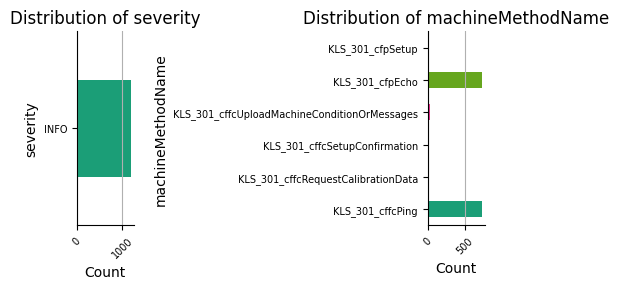

<ipython-input-42-2d3d5597bc4f>:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-42-2d3d5597bc4f>:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


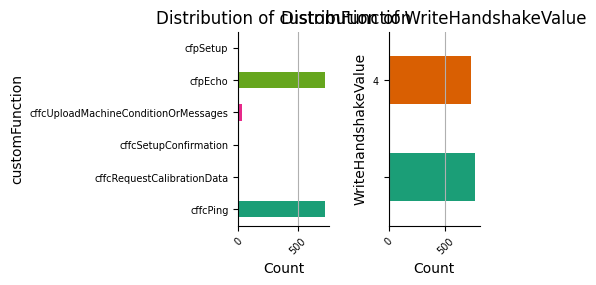

In [ ]:
fig = create2HBarPlots(ndf, ['severity', 'machineMethodName'], (5,3))
fig = create2HBarPlots(ndf, ['customFunction', 'WriteHandshakeValue'], (5,3))
#fig = create2HBarPlots(ndf, ['machineMethodName', ''], (5,3))

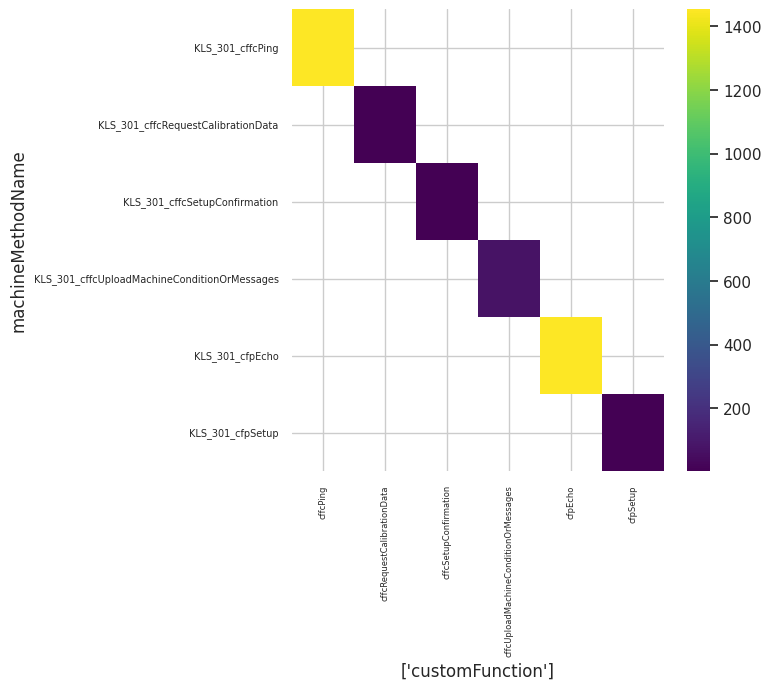

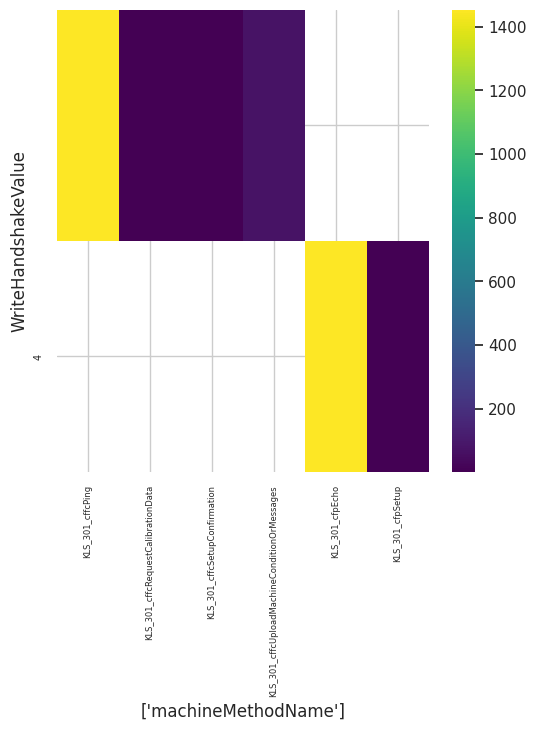

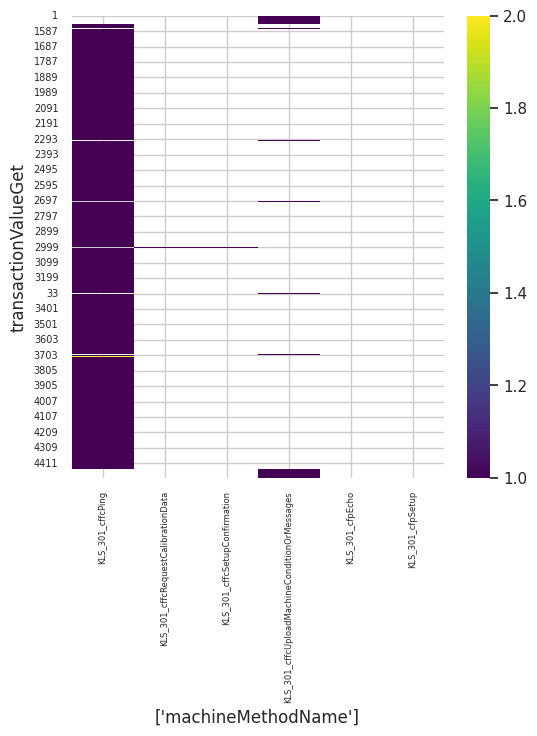

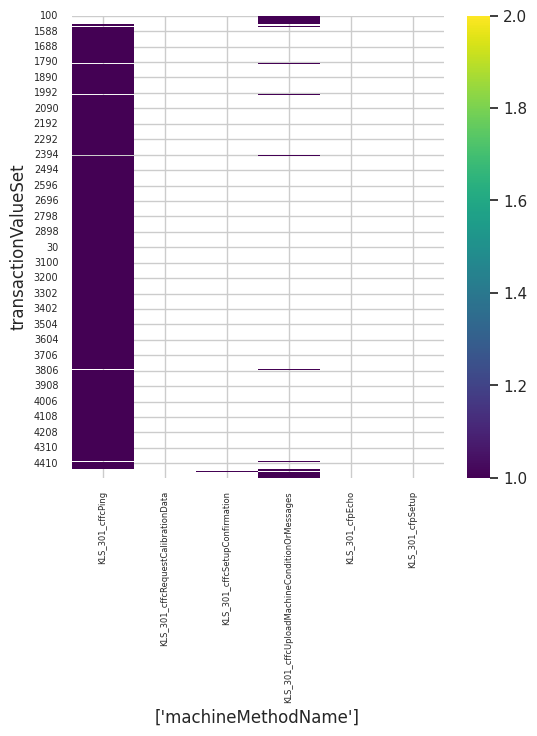

In [ ]:
fig = createHeatmap2D((6,6), ndf, ['customFunction'], 'machineMethodName')
fig = createHeatmap2D((6,6), ndf, ['machineMethodName'], 'WriteHandshakeValue')
fig = createHeatmap2D((6,6), ndf, ['machineMethodName'], 'transactionValueGet')
fig = createHeatmap2D((6,6), ndf, ['machineMethodName'], 'transactionValueSet')
fig.show()

In [ ]:
#fig = createChronoSeriesPlotPerColumn((10,6), ndf, ['transactionValue'], 'machineMethodName', 'filename.png' )

In [ ]:
ndf['callID']
# remove the None value
ndf_nono = ndf[ndf['callID'].notna()]
ndf_nono

,threadID,lineCount,date,datetime,callID,ThreadRange,completeTime,transactionValueGet,transactionValueSet,triggerWriteTime,...,topicValue,threadID,severity,starttime,endtime,readTime,executeTime,writeTime,NbMessages,messages
0,424185,22,2024-08-17,2024-08-17 13:44:40.256,267,760.0,705.90,1545,1546,18.20,...,None,424185,INFO,2024-08-17 13:44:39.550,2024-08-17 13:44:40.310,256.52,224.27,206.90,22,\nTRIGGER <TRANSACTION value:1545> received ->...
1,423698,22,2024-08-17,2024-08-17 13:44:40.659,267,646.0,378.46,None,None,NaN,...,30010230600180214/cfpEcho,423698,INFO,2024-08-17 13:44:40.214,2024-08-17 13:44:40.860,0.00,182.99,195.47,22,\nMessaging Event received for config: KLS_301...
3,424656,22,2024-08-17,2024-08-17 13:47:41.473,268,697.0,696.77,1547,1548,14.07,...,None,424656,INFO,2024-08-17 13:47:40.776,2024-08-17 13:47:41.473,259.79,181.41,241.50,22,\nTRIGGER <TRANSACTION value:1547> received ->...
4,424192,22,2024-08-17,2024-08-17 13:47:41.887,268,602.0,394.56,None,None,NaN,...,30010230600180214/cfpEcho,424192,INFO,2024-08-17 13:47:41.285,2024-08-17 13:47:41.887,0.00,173.59,220.97,22,\nMessaging Event received for config: KLS_301...
7,425182,22,2024-08-17,2024-08-17 13:50:42.699,269,599.0,687.93,1549,1550,14.13,...,None,425182,INFO,2024-08-17 13:50:42.100,2024-08-17 13:50:42.699,268.75,177.28,227.76,22,\nTRIGGER <TRANSACTION value:1549> received ->...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4511,85066,22,2024-08-20,2024-08-20 15:19:24.721,304,531.0,264.35,None,None,NaN,...,30010230600180214/cfpEcho,85066,INFO,2024-08-20 15:19:24.190,2024-08-20 15:19:24.721,0.00,177.21,87.14,22,\nMessaging Event received for config: KLS_301...
4513,86380,22,2024-08-20,2024-08-20 15:22:25.162,305,831.0,317.80,4445,4446,13.97,...,None,86380,INFO,2024-08-20 15:22:24.849,2024-08-20 15:22:25.680,19.25,193.21,91.36,22,\nTRIGGER <TRANSACTION value:4445> received ->...
4514,85724,22,2024-08-20,2024-08-20 15:22:25.724,305,484.0,245.13,None,None,NaN,...,30010230600180214/cfpEcho,85724,INFO,2024-08-20 15:22:25.240,2024-08-20 15:22:25.724,0.00,215.81,29.32,22,\nMessaging Event received for config: KLS_301...
4516,87036,22,2024-08-20,2024-08-20 15:25:26.150,306,898.0,322.06,4447,4448,11.97,...,None,87036,INFO,2024-08-20 15:25:25.822,2024-08-20 15:25:26.720,23.42,216.45,70.21,22,\nTRIGGER <TRANSACTION value:4447> received ->...


In [ ]:
#make the list of threadID where callID == 267
callID_267 = ndf_nono[ndf_nono['callID'] == '267']
callID_267.sample(5)


,threadID,lineCount,date,datetime,callID,ThreadRange,completeTime,transactionValueGet,transactionValueSet,triggerWriteTime,...,topicValue,threadID,severity,starttime,endtime,readTime,executeTime,writeTime,NbMessages,messages
2845,877335,22,2024-08-19,2024-08-19 13:26:26.200,267,740.0,362.24,3435,3436,13.97,...,None,877335,INFO,2024-08-19 13:26:25.660,2024-08-19 13:26:26.400,19.42,170.46,158.39,22,\nTRIGGER <TRANSACTION value:3435> received ->...
1412,635291,22,2024-08-18,2024-08-18 13:24:49.354,267,545.0,361.53,None,None,NaN,...,30010230600180214/cfpEcho,635291,INFO,2024-08-18 13:24:48.809,2024-08-18 13:24:49.354,0.00,180.26,181.27,22,\nMessaging Event received for config: KLS_301...
4399,60880,22,2024-08-20,2024-08-20 13:27:49.462,267,627.0,375.95,4369,4370,15.08,...,None,60880,INFO,2024-08-20 13:27:49.243,2024-08-20 13:27:49.870,145.23,190.17,25.47,22,\nTRIGGER <TRANSACTION value:4369> received ->...
0,424185,22,2024-08-17,2024-08-17 13:44:40.256,267,760.0,705.90,1545,1546,18.20,...,None,424185,INFO,2024-08-17 13:44:39.550,2024-08-17 13:44:40.310,256.52,224.27,206.90,22,\nTRIGGER <TRANSACTION value:1545> received ->...
2846,876724,22,2024-08-19,2024-08-19 13:26:26.410,267,453.0,231.67,None,None,NaN,...,30010230600180214/cfpEcho,876724,INFO,2024-08-19 13:26:25.957,2024-08-19 13:26:26.410,0.00,181.04,50.63,22,\nMessaging Event received for config: KLS_301...


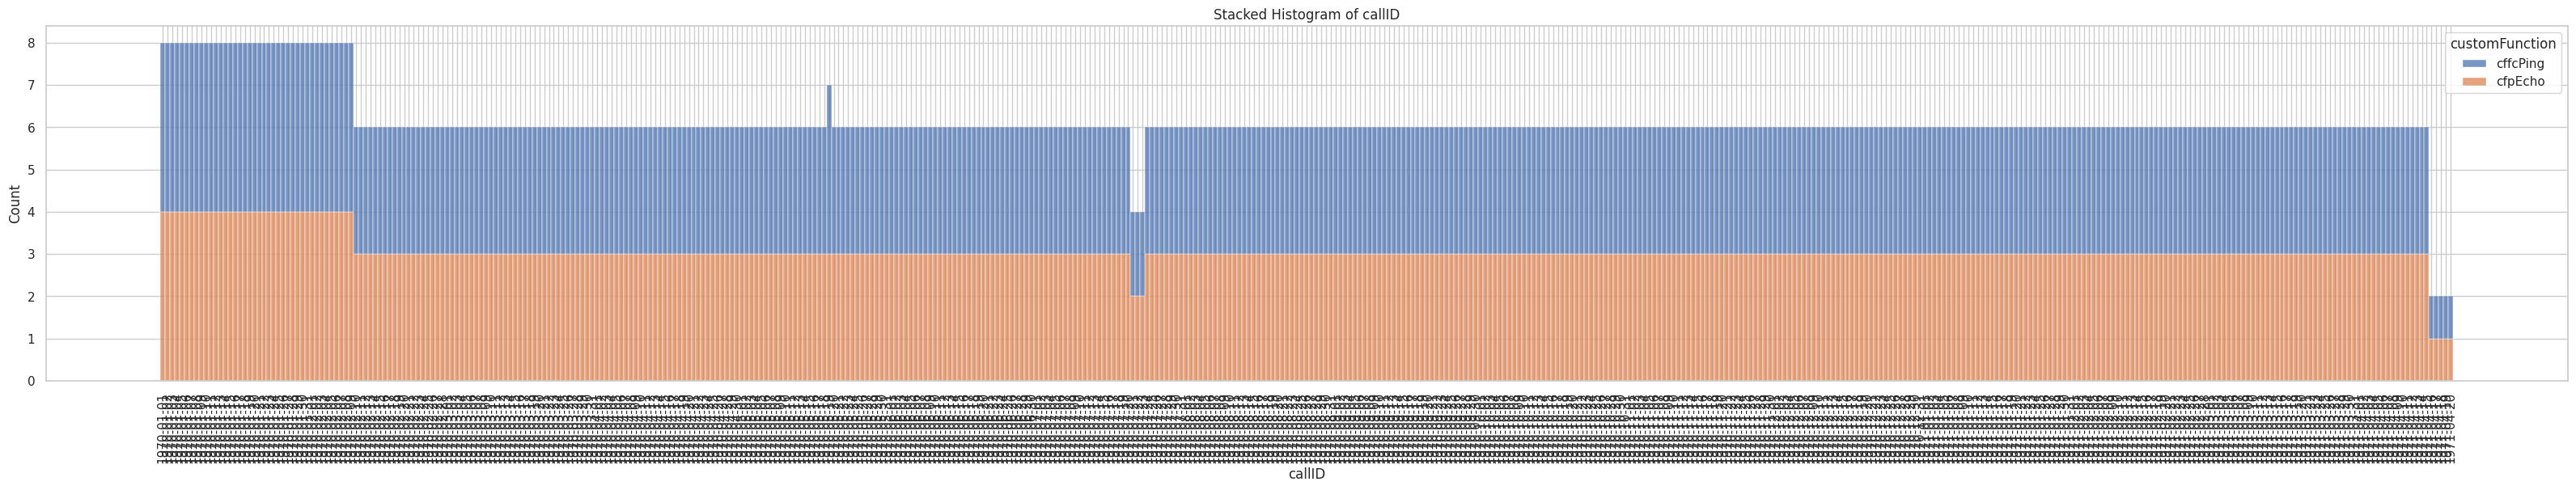

In [ ]:
# prompt: create a sns stack histoplot  of callID_267 'date' column per 'customFunction' column and add for the ticks a rotation 90 degree on x axis, give date format Y M D

import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

def createStakedHistoplot(df, x_column='date', hue_column='customFunction', title='', figsize=(12, 6)):
  # Create the stacked histogram plot
  plt.figure(figsize=figsize)
  sns.set(style="whitegrid")
  sns.histplot(df, x=x_column, hue=hue_column, multiple="stack", bins=10) #
  # Format the x-axis ticks
  plt.xticks(rotation=90)
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  # Adjust the layout to prevent labels from overlapping
  plt.tight_layout()
  plt.title('Stacked Histogram of '+title)
  plt.xlabel(x_column)
  plt.ylabel('Count')
  plt.show()


createStakedHistoplot(ndf_nono, 'callID', 'customFunction', 'callID', (32,6))

In [ ]:
filter_nodf = ndf_nono[ndf_nono['machineName'].isin(['cffcPing', 'cfpEcho'])]
createStakedHistoplot(filter_nodf, 'callID', 'machineName', 'callID', (32,6))

KeyError: 'machineName'

In [ ]:
# make a new column where date and callID are joined ?
ndf_nono['date_callID'] = ndf_nono['date'].astype(str) + '_' + ndf_nono['callID'].astype(str)
getShapeSize('ndf_nono', ndf_nono)
ndf_nono.sample(5)

Dataframe=ndf_nono has Number of rows: 2905 and columns : 26


<ipython-input-61-25e15e6952d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf_nono['date_callID'] = ndf_nono['date'].astype(str) + '_' + ndf_nono['callID'].astype(str)


,threadID,lineCount,date,datetime,callID,ThreadRange,completeTime,transactionValueGet,transactionValueSet,triggerWriteTime,...,threadID,severity,starttime,endtime,readTime,executeTime,writeTime,NbMessages,messages,date_callID
4043,1104875,22,2024-08-20,2024-08-20 08:03:45.785,161,422.0,213.22,None,None,NaN,...,1104875,INFO,2024-08-20 08:03:45.363,2024-08-20 08:03:45.785,0.00,183.32,29.90,22,\nMessaging Event received for config: KLS_301...,2024-08-20_161
1595,663682,22,2024-08-18,2024-08-18 16:29:37.603,328,422.0,232.54,None,None,NaN,...,663682,INFO,2024-08-18 16:29:37.181,2024-08-18 16:29:37.603,0.00,167.96,64.57,22,\nMessaging Event received for config: KLS_301...,2024-08-18_328
2431,798356,22,2024-08-19,2024-08-19 06:37:33.307,132,707.0,706.57,3165,3166,13.79,...,798356,INFO,2024-08-19 06:37:32.600,2024-08-19 06:37:33.307,243.63,177.52,271.62,22,\nTRIGGER <TRANSACTION value:3165> received ->...,2024-08-19_132
2555,816155,22,2024-08-19,2024-08-19 08:32:37.217,170,405.0,261.45,None,None,NaN,...,816155,INFO,2024-08-19 08:32:36.812,2024-08-19 08:32:37.217,0.00,183.42,78.03,22,\nMessaging Event received for config: KLS_301...,2024-08-19_170
3210,949120,22,2024-08-19,2024-08-19 19:16:13.365,380,484.0,183.42,None,None,NaN,...,949120,INFO,2024-08-19 19:16:12.881,2024-08-19 19:16:13.365,0.00,156.94,26.48,22,\nMessaging Event received for config: KLS_301...,2024-08-19_380


<ipython-input-45-39be2dc40f57>:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


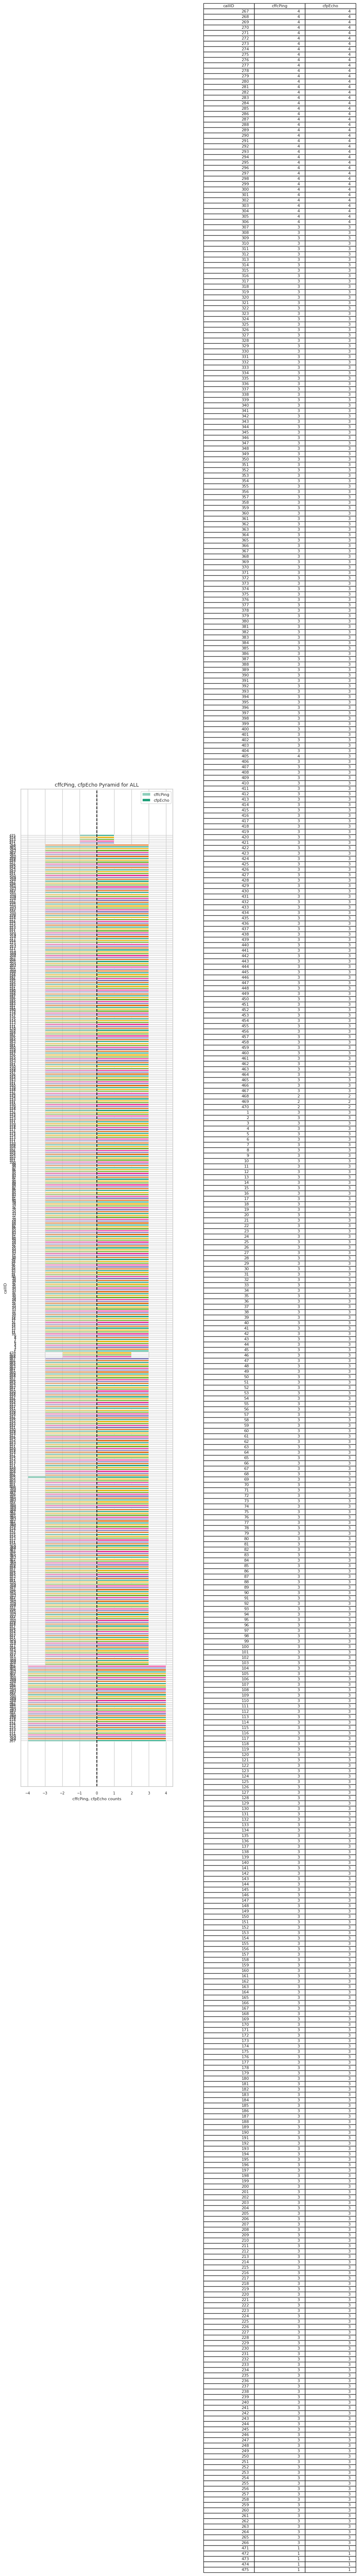

In [ ]:
#createPyramidGraph((12, 14), camera_df_IPCx, 'serialNumber', 'datetime', 'methodName', ['cfpCameraIn','cffcCameraOut' ], machine)
fig = createPyramidGraph((12,36), ndf_nono, 'callID', 'datetime', 'customFunction', ['cffcPing','cfpEcho'])

In [ ]:
# prompt: generate a method which can create pair of 2 rows where 'date_callID' is equal value and where 'customFunction' is either 'cffcPing', either 'cfpEcho' within ndf_nono
def find_pairs(df):
  """
  Generates pairs of rows where 'date_callID' is equal and 'customFunction' is either 'cffcPing' or 'cfpEcho'.
  Args: df:       The pandas DataFrame to search.
  Returns:        A list of pairs of rows that meet the criteria.
  """
  pairs = []
  for date_callID in df['date_callID'].unique():
    subset = df[df['date_callID'] == date_callID]
    if len(subset[subset['customFunction'] == 'cffcPing']) > 0 and len(subset[subset['customFunction'] == 'cfpEcho']) > 0:
      ping_row = subset[subset['customFunction'] == 'cffcPing'].iloc[0]
      echo_row = subset[subset['customFunction'] ==  'cfpEcho'].iloc[0]
      pairs.append((ping_row, echo_row))

  return pairs


In [ ]:
# Create a list to store the data for the DataFrame
def createPingEchoPair_DataFrame(ndf_pairs_list):
  # Create a list to store the data for the DataFrame
  data = []
  for ping_row, echo_row in ndf_pairs_list:
    elapsed_time = (echo_row['datetime'] - ping_row['datetime'])
    # Combine data from both rows into a single dictionary
    row_data = {
        'date': ping_row['date']
        ,'machineName': ping_row['machineMethodName']
        # Add other columns as needed
        ,'ping_customFunction': ping_row['customFunction']
        ,'ping_datetime': ping_row['datetime']
        ,'echo_customFunction': echo_row['customFunction']
        ,'echo_datetime': echo_row['datetime']
        ,'ping_completeTime': ping_row['completeTime']
        ,'echo_completeTime': echo_row['completeTime']
        , 'pingecho_elapsedTime_ms' : elapsed_time.total_seconds() * 1000
        ,'pingecho_elapsedTime': elapsed_time
        ,'callID': ping_row['callID']
        ,'ping_transactionValueGet': ping_row['transactionValueGet']
        ,'ping_transactionValueSet': ping_row['transactionValueSet']
        #,'ping_WriteHandshakeValue': ping_row['WriteHandshakeValue']
        #,'echo_transactionValue': echo_row['transactionValueGet']
        ,'echo_WriteHandshakeValue': echo_row['WriteHandshakeValue']
        # ...
    }
    data.append(row_data)
  # Create the DataFrame
  pairs_df = pd.DataFrame(data)
  return pairs_df


In [ ]:
# create pairs of two rows where where 'date_callID' is equal and where 'customFunction' is either 'cffcPing', either 'cfpEcho' within ndf_nono
ndf_pairs_list = find_pairs(ndf_nono)
print(f'Number of pairs: {len(ndf_pairs_list)}')

Number of pairs: 1452


In [ ]:
pingechoPair_df = createPingEchoPair_DataFrame(ndf_pairs_list)
getShapeSize('pingechoPair_df', pingechoPair_df)
pingechoPair_df

Dataframe=pingechoPair_df has Number of rows: 1452 and columns : 14


,date,machineName,ping_customFunction,ping_datetime,echo_customFunction,echo_datetime,ping_completeTime,echo_completeTime,pingecho_elapsedTime_ms,pingecho_elapsedTime,callID,ping_transactionValueGet,ping_transactionValueSet,echo_WriteHandshakeValue
0,2024-08-17,KLS_301_cffcPing,cffcPing,2024-08-17 13:44:40.256,cfpEcho,2024-08-17 13:44:40.659,705.90,378.46,403.0,0 days 00:00:00.403000,267,1545,1546,4
1,2024-08-17,KLS_301_cffcPing,cffcPing,2024-08-17 13:47:41.473,cfpEcho,2024-08-17 13:47:41.887,696.77,394.56,414.0,0 days 00:00:00.414000,268,1547,1548,4
2,2024-08-17,KLS_301_cffcPing,cffcPing,2024-08-17 13:50:42.699,cfpEcho,2024-08-17 13:50:43.132,687.93,300.28,433.0,0 days 00:00:00.433000,269,1549,1550,4
3,2024-08-17,KLS_301_cffcPing,cffcPing,2024-08-17 13:53:43.929,cfpEcho,2024-08-17 13:53:44.371,693.58,320.70,442.0,0 days 00:00:00.442000,270,1551,1552,4
4,2024-08-17,KLS_301_cffcPing,cffcPing,2024-08-17 13:56:45.169,cfpEcho,2024-08-17 13:56:45.581,729.04,302.11,412.0,0 days 00:00:00.412000,271,1553,1554,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,2024-08-20,KLS_301_cffcPing,cffcPing,2024-08-20 15:13:22.335,cfpEcho,2024-08-20 15:13:22.804,464.54,305.70,469.0,0 days 00:00:00.469000,302,4439,4440,4
1448,2024-08-20,KLS_301_cffcPing,cffcPing,2024-08-20 15:16:23.154,cfpEcho,2024-08-20 15:16:23.732,258.65,274.26,578.0,0 days 00:00:00.578000,303,4441,4442,4
1449,2024-08-20,KLS_301_cffcPing,cffcPing,2024-08-20 15:19:24.127,cfpEcho,2024-08-20 15:19:24.721,301.90,264.35,594.0,0 days 00:00:00.594000,304,4443,4444,4
1450,2024-08-20,KLS_301_cffcPing,cffcPing,2024-08-20 15:22:25.162,cfpEcho,2024-08-20 15:22:25.724,317.80,245.13,562.0,0 days 00:00:00.562000,305,4445,4446,4


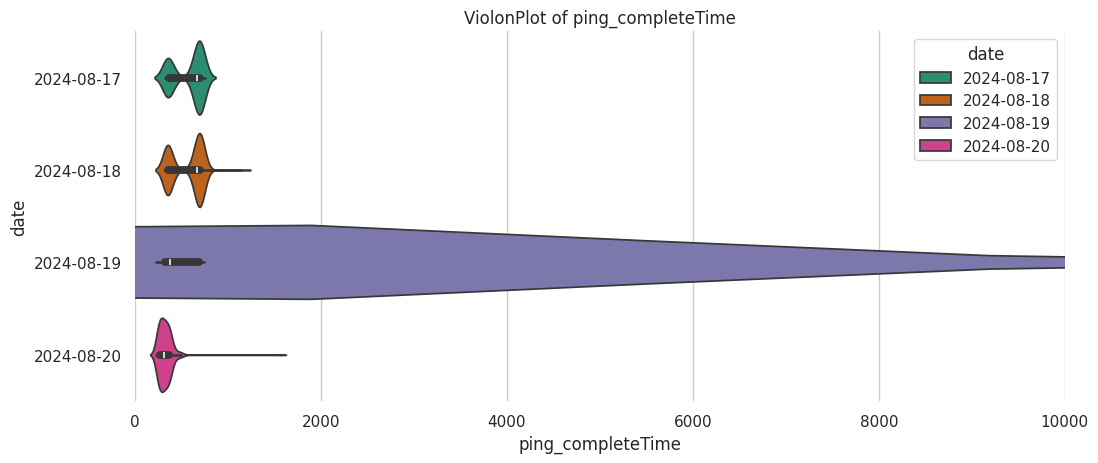

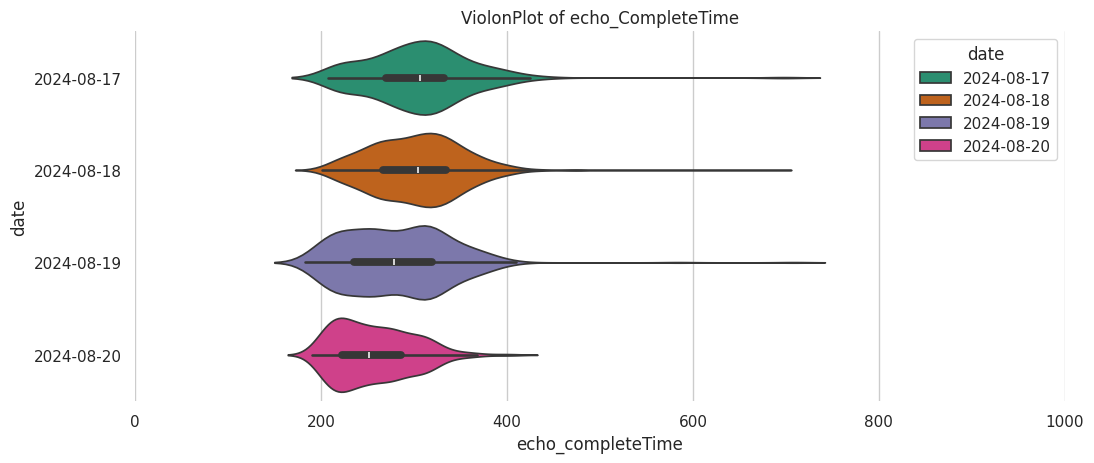

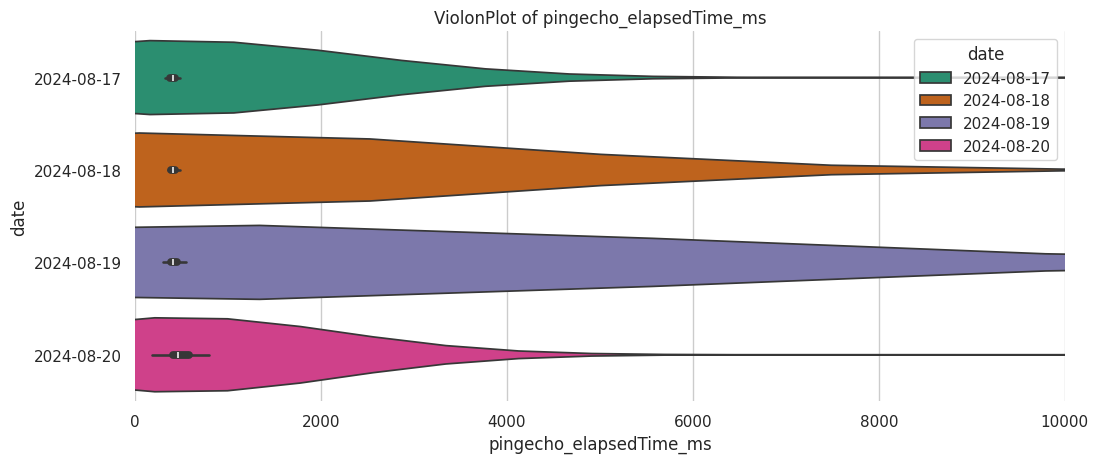

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

def createViolinPlot(df, x_column, y_column, hue_column, title='', figsize=(12, 6), xmin=None, xmax=None):
  figsize = (12, 1.2 * len(pingechoPair_df[y_column].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(pingechoPair_df, x=x_column, y=y_column, hue=hue_column, inner='box', palette='Dark2')
  sns.despine(top=True, right=True, bottom=True, left=True)
  plt.title(title)
  plt.xlabel(x_column)
  plt.ylabel(y_column)
  # Add this line to cap the maximum value on the x-axis
  if xmax is not None or xmin is not None:
    plt.xlim(left=xmin, right=xmax)
  plt.show()

createViolinPlot(pingechoPair_df, 'ping_completeTime', 'date', 'date', 'ViolonPlot of ping_completeTime', (12,8), xmin=0, xmax=10000)  # Replace 100 with your desired maximum value
createViolinPlot(pingechoPair_df, 'echo_completeTime', 'date', 'date', 'ViolonPlot of echo_CompleteTime', (12,8), xmin=0, xmax=1000)
createViolinPlot(pingechoPair_df, 'pingecho_elapsedTime_ms', 'date', 'date', 'ViolonPlot of pingecho_elapsedTime_ms', (12,8), xmin=0, xmax=10000)

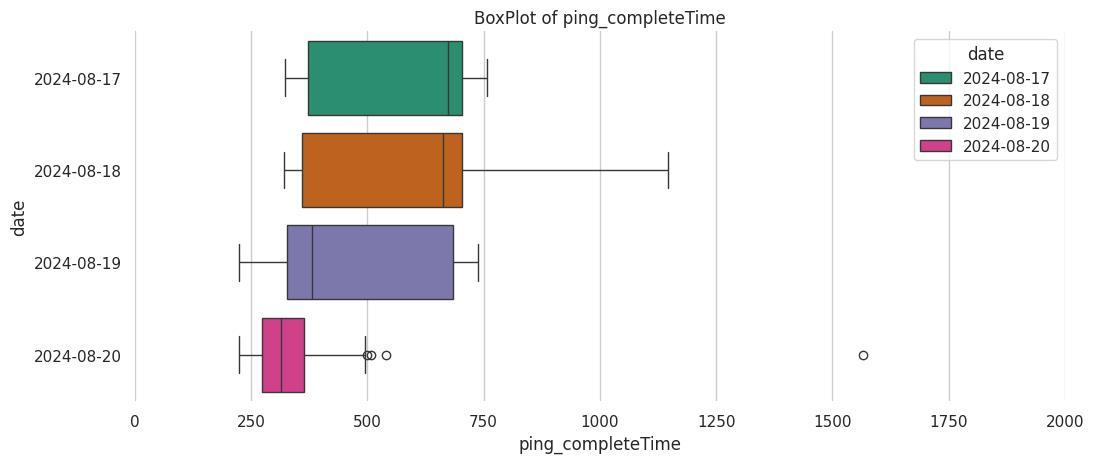

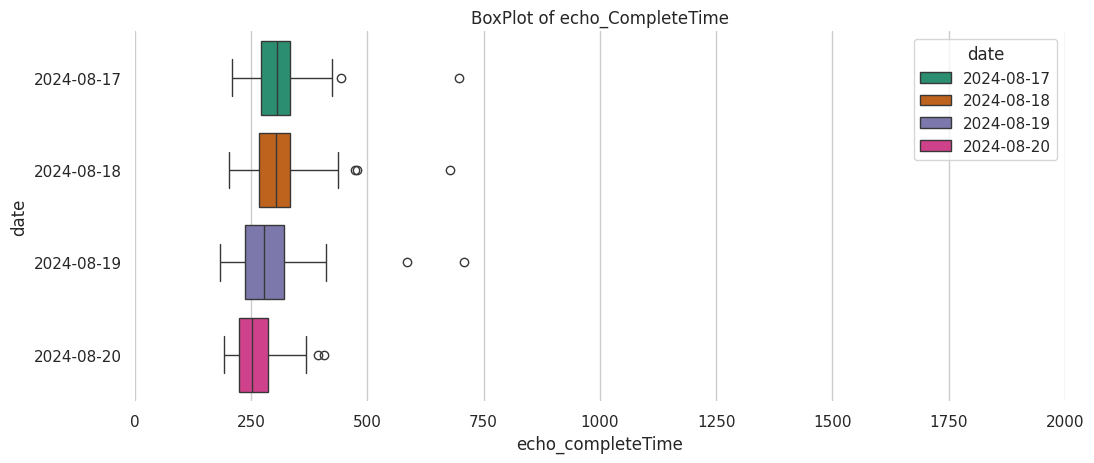

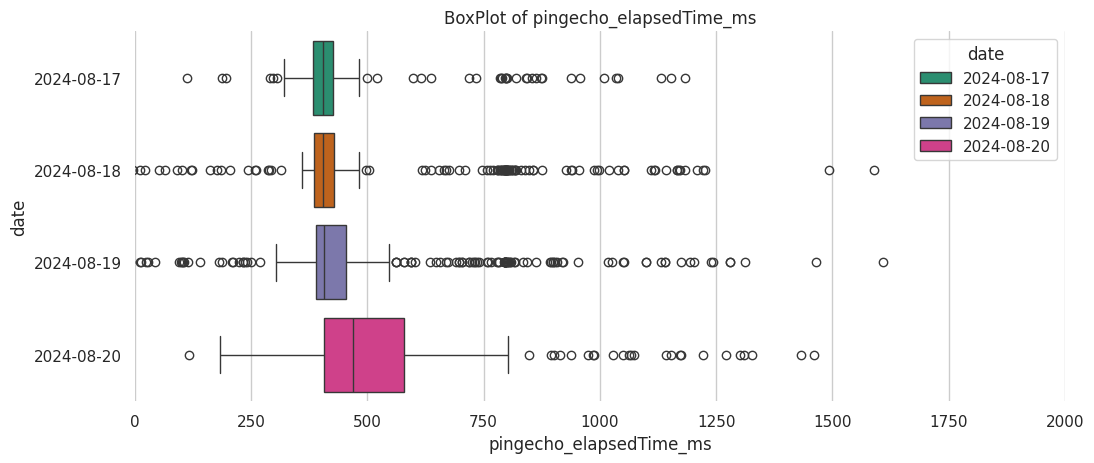

In [ ]:
# prompt: generate competitive graphs than createViolinPlot to display elapsed time deviation per date ?

def createBoxPlot(df, x_column, y_column, hue_column, title='', figsize=(12, 6), xmin=None, xmax=None):
  figsize = (12, 1.2 * len(pingechoPair_df[y_column].unique()))
  plt.figure(figsize=figsize)
  sns.boxplot(pingechoPair_df, x=x_column, y=y_column, hue=hue_column, palette='Dark2')
  sns.despine(top=True, right=True, bottom=True, left=True)
  plt.title(title)
  plt.xlabel(x_column)
  plt.ylabel(y_column)
  # Add this line to cap the maximum value on the x-axis
  if xmax is not None or xmin is not None:
    plt.xlim(left=xmin, right=xmax)
  plt.show()

createBoxPlot(pingechoPair_df, 'ping_completeTime', 'date', 'date', 'BoxPlot of ping_completeTime', (12,8), xmin=0, xmax=2000)  # Replace 100 with your desired maximum value
createBoxPlot(pingechoPair_df, 'echo_completeTime', 'date', 'date', 'BoxPlot of echo_CompleteTime', (12,8), xmin=0, xmax=2000)
createBoxPlot(pingechoPair_df, 'pingecho_elapsedTime_ms', 'date', 'date', 'BoxPlot of pingecho_elapsedTime_ms', (12,8), xmin=0, xmax=2000)


In [ ]:
from matplotlib import pyplot as plt
pingechoPair_df['echo_completeTime'].plot(kind='line', figsize=(8, 4), title='echo_completeTime')
plt.gca().spines[['top', 'right']].set_visible(False)

## VIS Exe

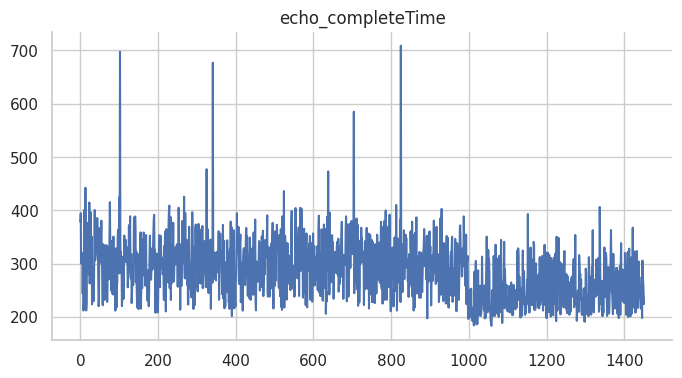

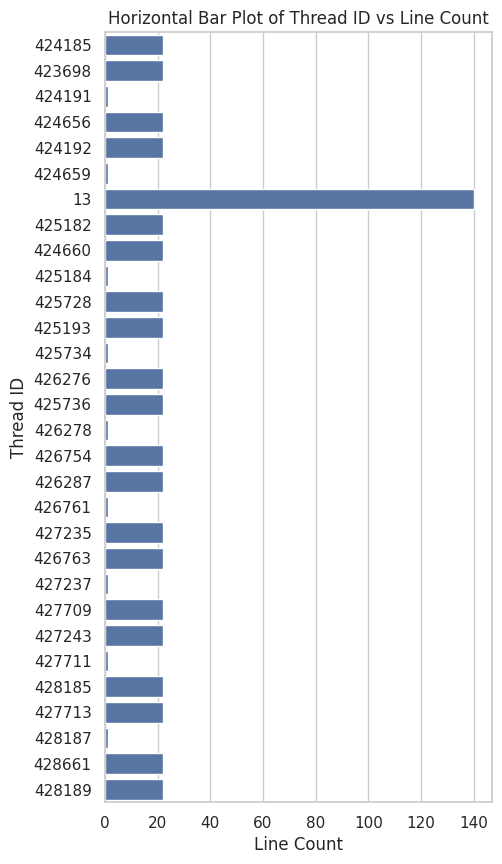

In [ ]:
def createSnSHBarPlot(rdf):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5, 10))  # Set the figure size
    sns.barplot(y='threadID', x='lineCount', data=rdf, orient='h')  # Create horizontal bar plot
    plt.xlabel('Line Count')  # Label for x-axis
    plt.ylabel('Thread ID')    # Label for y-axis
    plt.title('Horizontal Bar Plot of Thread ID vs Line Count')  # Title of the plot
    plt.show()  # Display the plot

# Call the function with your DataFrame
createSnSHBarPlot(threads_head)


In [ ]:

# Now, call the function and display the chart
# hbar_chart = createHBarPlot(threads_head)
# hbar_chart  # This will display the chart in a Jupyter notebook or similar environment

In [ ]:
#publishTasksHandShakeReader = HandshakeReader(source_folder + source_filename_log, pattern_dico)
#gdf = publishTasksHandShakeReader.read_handshake(year=2024)
#getShapeSize('gdf', gdf)